In [1]:
import os
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#sns.set_style("darkgrid")
sns.set_theme(style="whitegrid")

import folium

In [2]:
df = pd.read_csv("CATI_LPK_MASZK_2021_10_hullam_2021_10_compl_20211030_clean_Renyi.csv",
           sep=';',
           header=0)

# Fix data
df = df.replace("Kömlő", "Kömlőd")
df = df.replace("Hódosér (bakonyszentlászló)", "Bakonyszentlászló")

# Merge KSH
KSH = pd.read_csv("HU_places_admin_pop_ZIP_latlon.csv",
           sep=',',
           header=0)
df=pd.merge(df, KSH, left_on="K15A", right_on="place")

# Add central Hungary
pest = ["Budapest"]+["Alsónémedi","Biatorbágy","Budajenő","Budakalász","Budakeszi","Budaörs","Csobánka","Csomád","Csömör","Csörög","Dabas","Délegyháza","Diósd","Dunabogdány","Dunaharaszti","Dunakeszi","Dunavarsány","Ecser","Erdőkertes","Érd","Felsőpakony","Fót","Göd","Gödöllő","Gyál","Gyömrő","Halásztelek","Herceghalom","Inárcs","Isaszeg","Kakucs","Kerepes","Kistarcsa","Kisoroszi","Leányfalu","Majosháza","Maglód","Mogyoród","Monor","Nagykovácsi","Nagytarcsa","Ócsa","Őrbottyán","Páty","Perbál","Pécel","Pilisborosjenő","Piliscsaba","Pilisjászfalu","Pilisszántó","Pilisszentiván","Pilisszentkereszt","Pilisszentlászló","Pilisvörösvár","Pomáz","Pócsmegyer","Pusztazámor","Remeteszőlős","Solymár","Sóskút","Szada","Százhalombatta","Szentendre","Szigethalom","Szigetmonostor","Szigetszentmiklós","Sződ","Sződliget","Tahitótfalu","Taksony","Tárnok","Telki","Tinnye","Tök","Tököl","Törökbálint","Újhartyán","Újlengyel","Üllő","Üröm","Vác","Vácrátót","Vecsés","Veresegyház","Visegrád","Zsámbék"]
no_pest = [k for k in set(df["K15A"].array) if k not in pest]
pest = [k for k in set(df["K15A"].array) if k in pest]

centralHun = pd.DataFrame({
    "central":np.concatenate((np.ones(len(pest), dtype=int), np.zeros(len(no_pest), dtype=int))),
    "K15A":pest+no_pest
})
df=df.merge(centralHun, on="K15A")

city_sizes = pd.read_csv("hnk_2019.csv", sep=",", skiprows=[1])
city_sizes = {r["Helység"]:float(r["Terület  (hektár)"].replace(',', '')) for i,r in city_sizes.iterrows()}

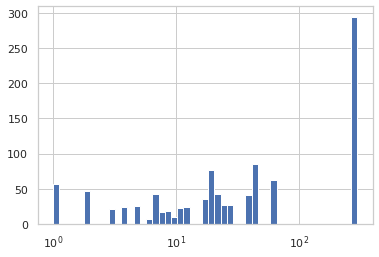

In [3]:
normed = pd.DataFrame(df[["K91_01", "K91_02", "K91_03", "K91_06", "SZUL", "population"]])
for col in ["K91_01", "K91_02", "K91_03", "K91_06"]:
    normed.loc[:,col]-=normed["K91_06"]
    
normed["size"]=normed[["K91_01", "K91_02", "K91_03", "K91_06"]].\
             groupby(["K91_01", "K91_02", "K91_03", "K91_06"])["K91_01"].transform('size')

normed["size"].hist(bins=np.logspace(np.log10(1.0),np.log10(300), 50))
plt.xscale("log")
plt.show()

In [4]:
funcs = pd.DataFrame(normed[["K91_01", "K91_02", "K91_03", "K91_06"]].\
             groupby(["K91_01", "K91_02", "K91_03", "K91_06"]).\
             size().sort_values(ascending=False).\
             reset_index(name="size"),
            )
print(len(funcs))
funcs[funcs["size"]>1][:20]

for i in [1,2,5,10,15,25]:
    frequent_functions = sum(funcs[funcs["size"]>i]["size"])
    print(f"Functions > {i}: {frequent_functions}")
plt.show()

128
Functions > 1: 944
Functions > 2: 898
Functions > 5: 828
Functions > 10: 736
Functions > 15: 690
Functions > 25: 536


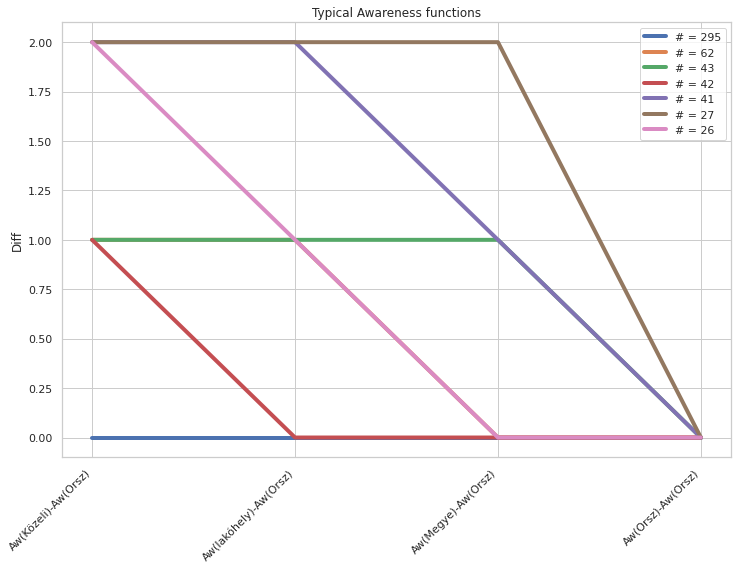

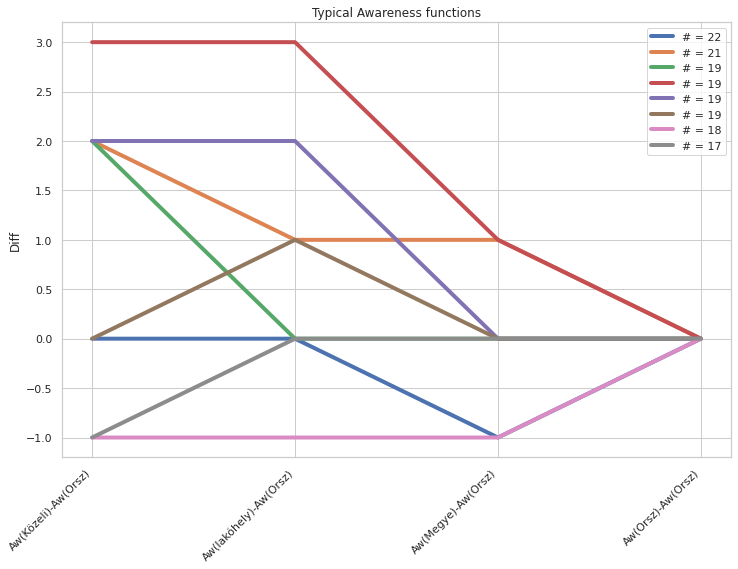

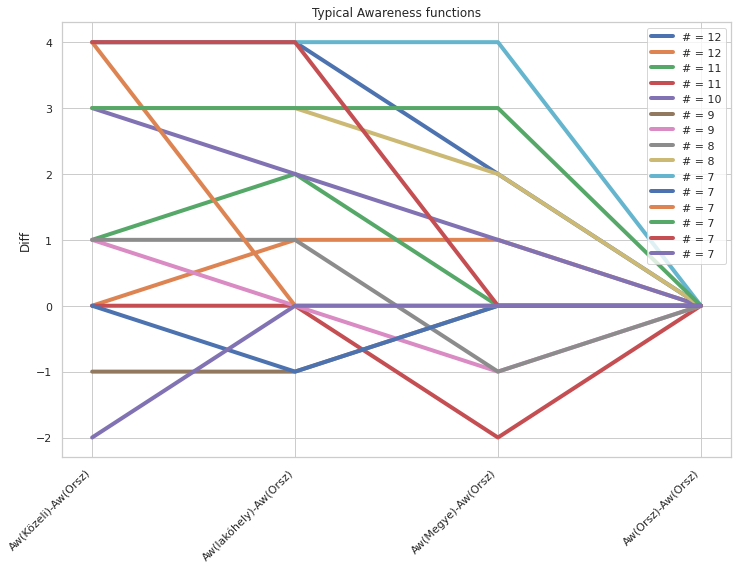

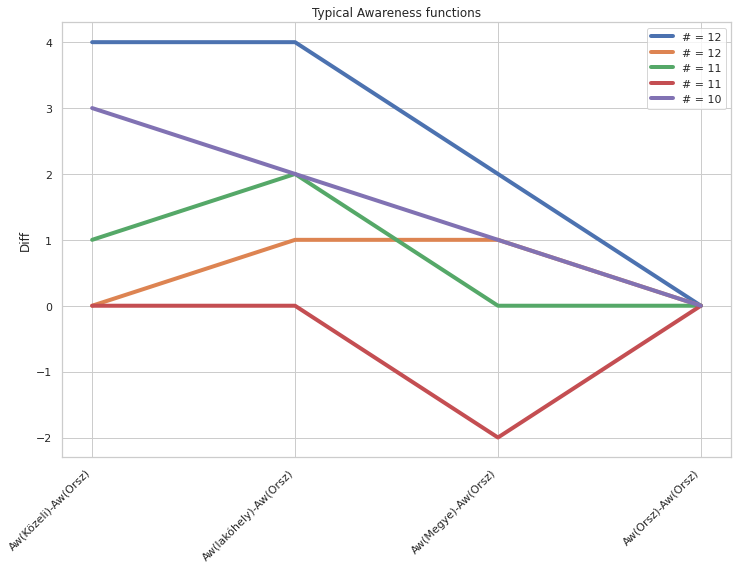

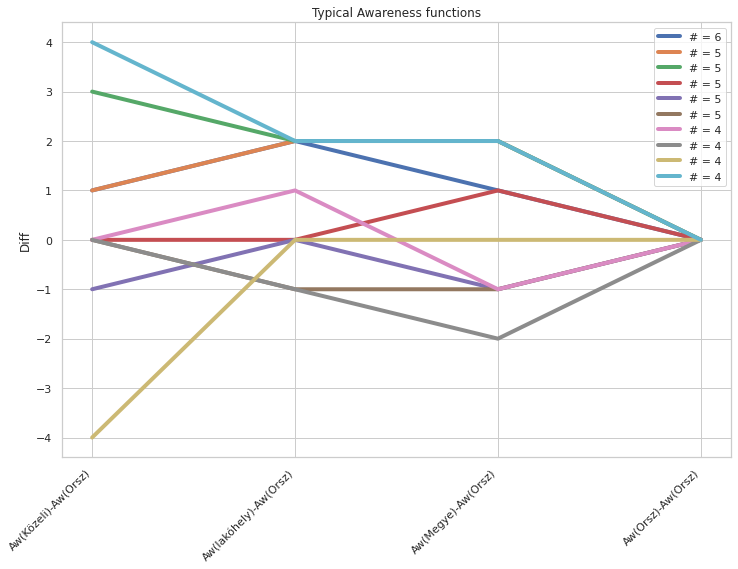

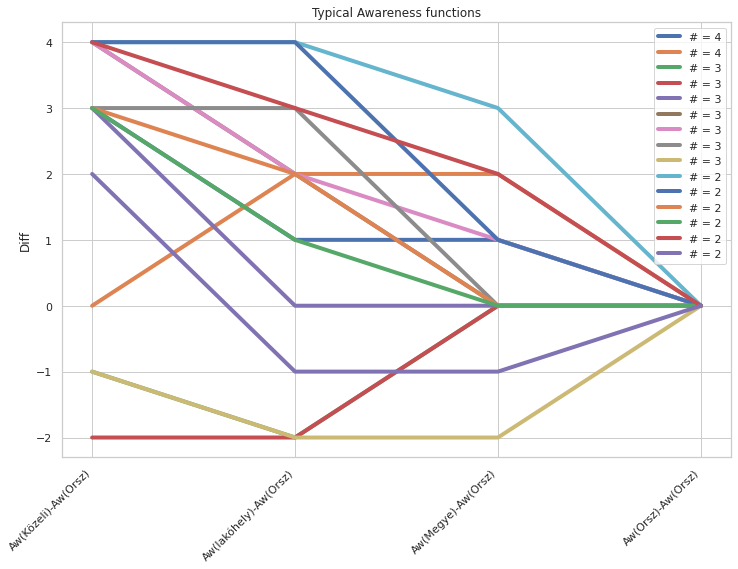

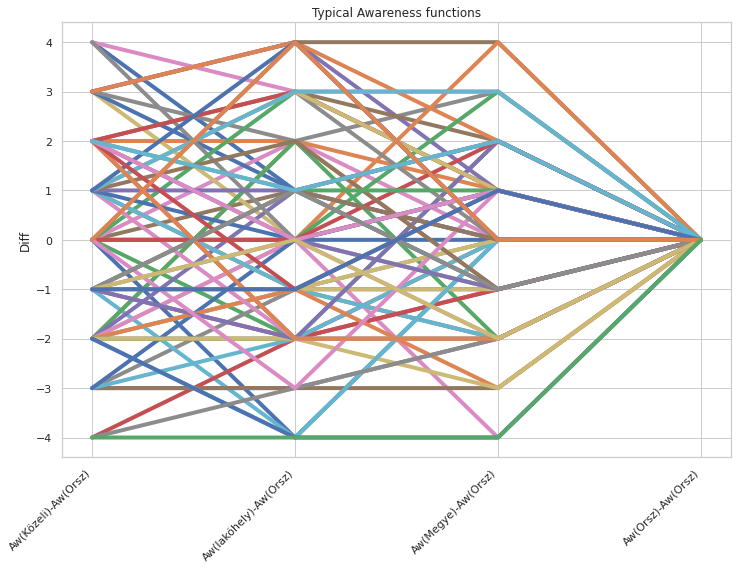

In [5]:
for a,b in [(0,7),(7,15),(15,30), (15,20), (30,40), (40,55), (55,128)]:
    xlabel = ["Aw(Közeli)-Aw(Orsz)", "Aw(lakóhely)-Aw(Orsz)", "Aw(Megye)-Aw(Orsz)", "Aw(Orsz)-Aw(Orsz)"]
    plt.figure(figsize=(12,8))
    for i in range(a,b):
        arr = funcs.iloc[i].to_numpy()
        x,y = arr[:4], arr[4]

        plt.plot(xlabel,x, label=f"# = {y}", linewidth=4)

    plt.ylabel("Diff")
    plt.xticks(xlabel)
    plt.gca().set_xticklabels(xlabel, rotation = 45, ha="right")
    if b-a <= 20: plt.legend()
    plt.title("Typical Awareness functions")
    plt.show()

In [6]:
normed["std"] = np.std(normed[["K91_01", "K91_02", "K91_03", "K91_06"]].to_numpy(), axis=1)
print(f"Constant: {sum(normed['std']==0)}")
print(f'Constant (begin equals end): {sum(normed["K91_06"]==normed["K91_01"])}')
print(f'Decreased by 1: {sum(normed["K91_06"]==normed["K91_01"]-1)}')
print(f'Decreased by 2: {sum(normed["K91_06"]==normed["K91_01"]-2)}')
print(f'Decreased by 3: {sum(normed["K91_06"]==normed["K91_01"]-3)}')
print(f'Decreased by 4: {sum(normed["K91_06"]==normed["K91_01"]-4)}')
print(f'Increasing: {sum(normed["K91_06"]>normed["K91_01"])}')

Constant: 295
Constant (begin equals end): 405
Decreased by 1: 198
Decreased by 2: 168
Decreased by 3: 69
Decreased by 4: 53
Increasing: 107


In [7]:
def get_categories_pos():
    arr = np.zeros(1000, dtype=int)
    for i in range(1000):
        l = normed.iloc[i].to_numpy()[:4]
        if(l[0]==0 and l[-1]==0 and l[1]==0 and l[2]==0):
            arr[i]=0
        elif(np.any(l<0)):
            arr[i]=3
        elif(l[0]-l[-1]==1):
            arr[i]=1
        else:
            arr[i]=2
    return np.array(arr)

1000
1000


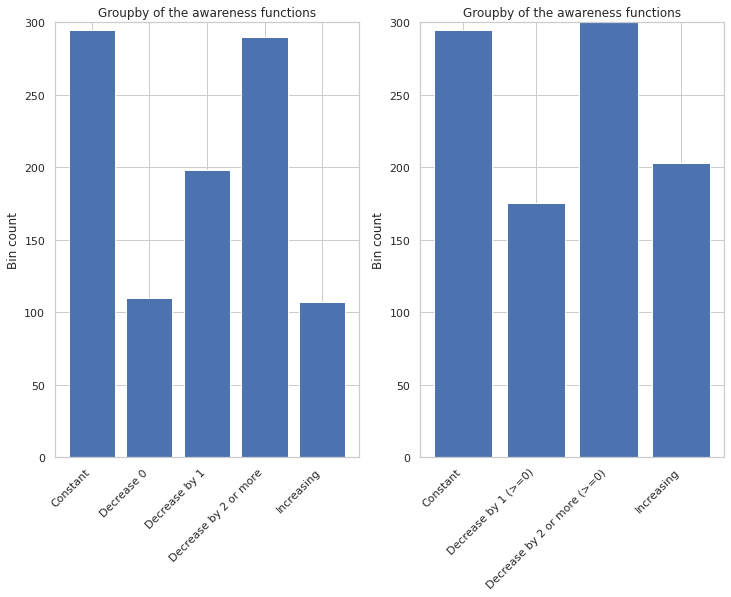

In [8]:
# === Without filtering negatives:
plt.figure(figsize=(12,8))
ax = plt.subplot(121)
x = ["Constant", "Decrease 0", "Decrease by 1", "Decrease by 2 or more", "Increasing"]
y = [sum(normed['std']==0),
     sum(normed["K91_06"]==normed["K91_01"])-sum(normed['std']==0),
     sum(normed["K91_06"]==normed["K91_01"]-1),
     sum(normed["K91_06"]<normed["K91_01"]-1),
     sum(normed["K91_06"]>normed["K91_01"])]

print(sum(y))
plt.bar(x,y)
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=45, ha="right")
plt.title("Groupby of the awareness functions")
plt.ylabel("Bin count")
plt.ylim([0,300])

# === Filtering negatives:
ax = plt.subplot(122)
#arr_Gergo = np.array([0,1,3,0,2,0,0,0,2,1,1,2,0,0,2,1,2,0,1,3,3,3,3,0,2,0,2,1,1,0,2,2,3,2,2,3,2,2,1,3,2,2,2,2,3,1,2,0,2,2,2,0,1,3,3,2,2,0,1,1,0,2,3,2,2,3,2,1,2,1,0,0,0,2,3,3,1,1,3,2,3,3,2,0,2,0,2,3,2,2,2,2,2,0,0,2,2,2,2,1,0,3,1,3,2,3,3,0,0,2,1,2,0,2,2,1,1,3,0,0,2,2,2,0,0,3,2,2,0,1,0,0,0,2,2,0,3,0,3,3,3,0,0,1,0,2,1,0,1,0,2,3,1,2,2,2,0,0,2,3,0,1,2,0,2,0,2,0,1,3,0,1,1,2,3,2,0,0,0,2,2,2,0,0,3,2,0,0,0,3,2,2,0,0,3,1,0,0,2,0,2,0,1,3,0,0,2,3,3,2,0,0,3,3,0,0,3,0,2,0,2,0,2,2,2,0,2,2,1,2,3,2,2,1,0,3,1,0,3,1,2,0,3,3,3,3,1,1,1,3,0,3,3,3,2,0,1,0,3,2,2,2,1,2,3,0,2,3,1,0,2,0,0,2,3,2,2,1,2,2,2,0,3,3,0,3,0,0,1,3,3,0,3,2,3,0,0,0,0,0,2,1,2,0,0,0,1,3,2,2,1,1,1,2,0,2,2,2,2,3,0,2,0,2,3,2,2,1,0,3,2,0,0,1,3,2,2,2,2,0,0,0,1,2,0,0,3,3,2,0,0,1,3,3,2,2,2,2,0,3,2,3,0,0,3,1,3,3,3,3,2,3,3,0,2,3,0,2,1,2,0,2,1,0,3,0,1,2,2,2,0,0,0,1,2,1,2,2,2,2,1,3,2,2,0,1,3,3,0,1,1,2,0,0,2,2,3,1,0,2,2,0,0,2,0,3,1,0,0,0,1,2,2,1,1,3,1,2,1,0,0,0,2,3,1,0,2,2,0,0,0,1,0,1,2,1,2,3,2,2,0,2,2,0,2,2,1,0,1,0,3,2,1,2,2,0,0,1,2,1,1,0,3,3,0,3,3,2,2,3,0,2,3,1,3,2,1,1,0,3,3,2,3,0,3,3,3,0,3,2,0,2,2,3,2,0,1,0,3,2,0,1,0,1,0,1,0,1,1,0,3,2,0,2,3,2,2,3,3,2,3,2,3,1,2,2,1,3,3,0,3,2,0,3,1,0,0,0,0,0,0,0,3,3,2,0,0,0,3,0,1,1,0,0,2,0,0,0,2,2,0,2,2,1,3,0,3,2,1,1,1,2,3,2,1,2,2,2,0,0,0,2,0,0,3,1,2,0,2,0,0,1,0,0,0,3,0,2,0,2,2,2,1,3,2,3,1,2,0,0,1,3,0,0,1,2,2,2,2,1,3,2,2,0,1,0,2,2,2,3,0,2,1,1,3,2,1,1,0,0,1,1,0,2,3,2,2,3,2,0,1,0,0,3,1,3,3,2,1,1,2,2,2,2,1,2,0,2,2,1,1,0,2,1,3,2,1,3,1,0,0,0,2,2,0,1,3,3,0,3,2,0,0,2,2,2,2,2,0,3,1,2,0,0,2,2,0,3,2,3,2,3,0,0,1,1,0,0,0,2,1,1,2,2,0,3,1,2,3,0,2,3,2,2,2,1,3,3,0,1,2,2,2,3,0,3,2,3,3,2,3,0,0,2,2,1,0,3,2,3,2,0,0,2,0,2,2,2,0,3,1,0,2,1,3,3,0,0,0,2,2,2,2,0,1,0,0,1,3,3,0,0,3,0,3,2,1,3,3,1,3,2,3,0,2,1,2,1,1,3,1,2,1,3,3,0,2,3,0,1,2,1,0,1,0,1,0,2,2,3,0,3,2,2,3,0,2,2,0,2,0,1,3,3,3,3,3,0,0,0,0,3,3,2,2,0,3,2,0,1,0,3,0,0,2,3,3,3,3,2,2,0,2,2,0,3,2,1,3,0,2,3,0,3,3,3,0,2,2,3,3,3,3,0,3,0,0,3,1,0,0,1,0,0,0,1,2,0,3,3,2,0,1,1,3,2,1,2,2,0,2,2,2,1,0,2,2,0,3,0,0,2,3,0,2,2,0,0,1,2,2,1,1,0,1,2,0,0,0,3,3,1,0,3,1,3,0,2,2,1,3,3,3,2,0,3,0,2,2,3,3,2,0,2,3,3,3,3,2,3])
arr = get_categories_pos()
y = [np.sum(arr==0),np.sum(arr==1), np.sum(arr==2), np.sum(arr==3)]
x = ["Constant", "Decrease by 1 (>=0)", "Decrease by 2 or more (>=0)", "Increasing"]

print(sum(y))
plt.bar(x,y)
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=45, ha="right")
plt.title("Groupby of the awareness functions")
plt.ylabel("Bin count")
plt.ylim([0,300])
plt.show()

In [9]:
def plot_key_hist(key, bins, title, **kwargs):
    args = {
        'ha':'center',
        
    }
    for k,v in kwargs.items():
        args[k]=v
        print(k,v)
    
    color_labels = ["Constant", "Decrease by 1 (>=0)", "Decrease by 2 or more (>=0)", "Increasing"]
    
    
    labels = [f"{bins[i-1]}-{bins[i]}" for i in range(1,len(bins))]
    x = np.arange(1,len(labels)+1)
    
    def my_barplot(h_scale1, h_scale2, h_label, ylabel, title):
        w = 0.2
        
        h,b = np.histogram(df[key], bins=bins)
        plt.bar(x, h/h_scale1, width=1.0, label=h_label, color="gray", alpha=0.5)

        for i in range(4):
            h, b = np.histogram(df[arr == i][key], bins=bins)
            N = len(df[arr == i])
            scale = N**h_scale2
            plt.bar(x-(i+1)*w+0.5,h/scale, width=w, label=f"{color_labels[i]} [#{N}]")

        plt.xticks(x)
        plt.gca().set_xticklabels(labels, ha=args['ha'], rotation=45);
        plt.title(title)
        plt.ylabel(ylabel)
        plt.legend()
        
    
    plt.figure(figsize=(15,8))
    
    plt.subplot(121)
    my_barplot(4.0, 0.0,
               "Original (/4)",
               title=f'{title} histogram',
               ylabel="Bins")
    
    plt.subplot(122)
    my_barplot(1000.0, 1.0,
               "Original",
               title=f'{title} distribution',
               ylabel="Ratio in group")
    
    plt.show()


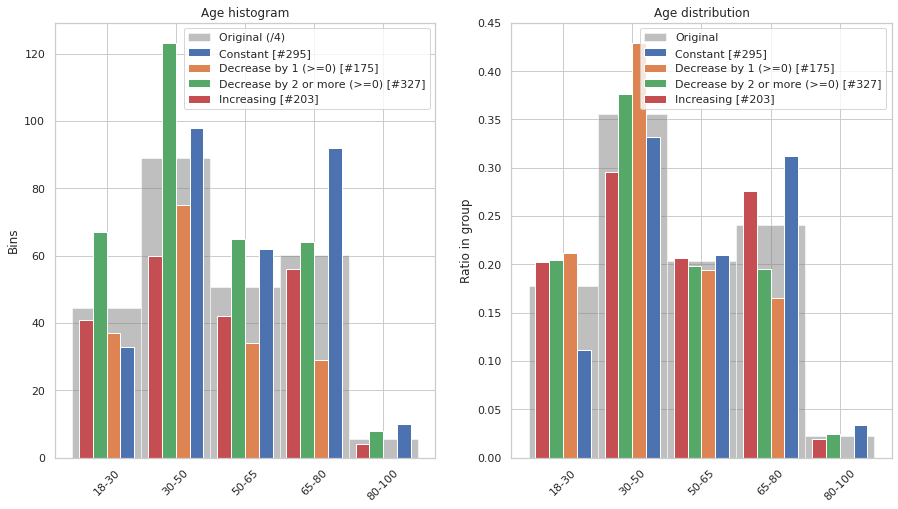

In [10]:
plot_key_hist("SZUL", bins=[18,30,50,65,80,100], title="Age")

ha right


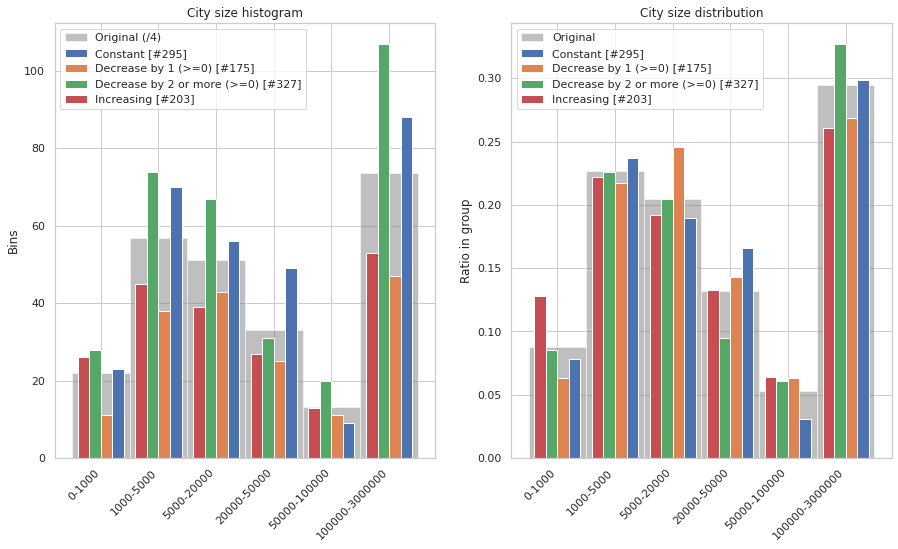

In [11]:
plot_key_hist("population", bins=list([0,1000,5000,20000,50000,100000,3000000]), title="City size", ha='right')

ha right


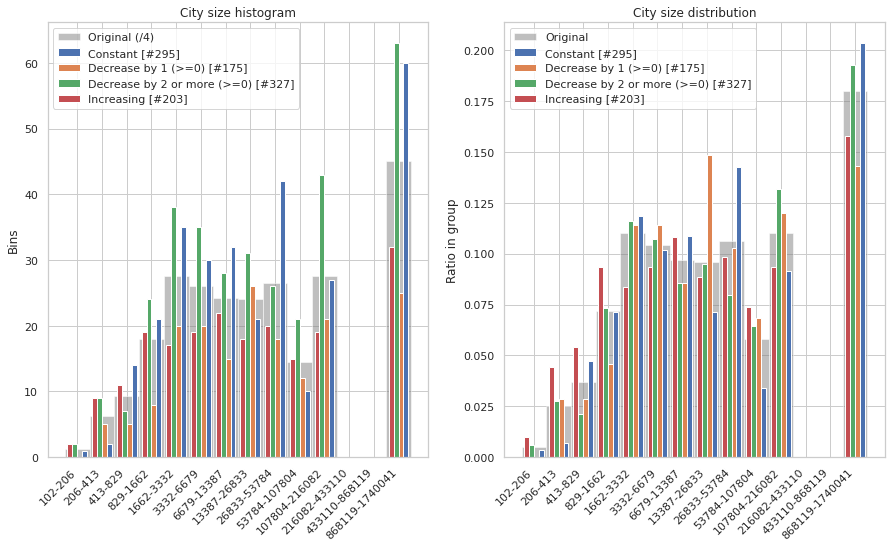

In [12]:
plot_key_hist("population", bins=np.logspace(np.log10(103),np.log10(1740041.0), 15).astype(np.int32), title="City size", ha='right')

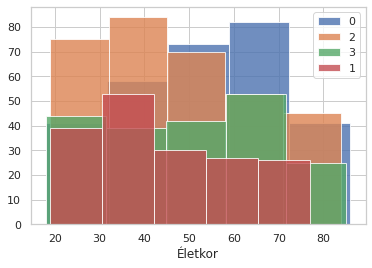

In [13]:
for i in [0,2,3,1]:
    df[arr == i]["SZUL"].hist(bins=5, label=i, alpha=.8)

plt.xlabel("Életkor")
plt.legend()

103 1740041


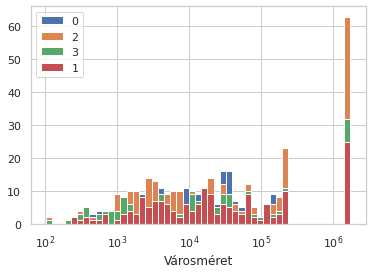

In [14]:
print(min(df["population"]), max(df["population"]))

for i in [0,2,3,1]:
    df[arr == i]["population"].hist(bins=np.logspace(np.log10(103),np.log10(1740041.0), 50), label=i, alpha=1.0)

plt.xlabel("Városméret")
plt.xscale("log")
plt.legend()
plt.show()

# Awareness Function shape

In [15]:
survey_column = {
    "Közeli ismerős":"K91_01",
    "Lakóhely":"K91_02",
    "Megye":"K91_03",
    "Főváros":"K91_05",
    "Ország":"K91_06",
    "Európa":"K91_08",
    "Világ":"K91_09",
}

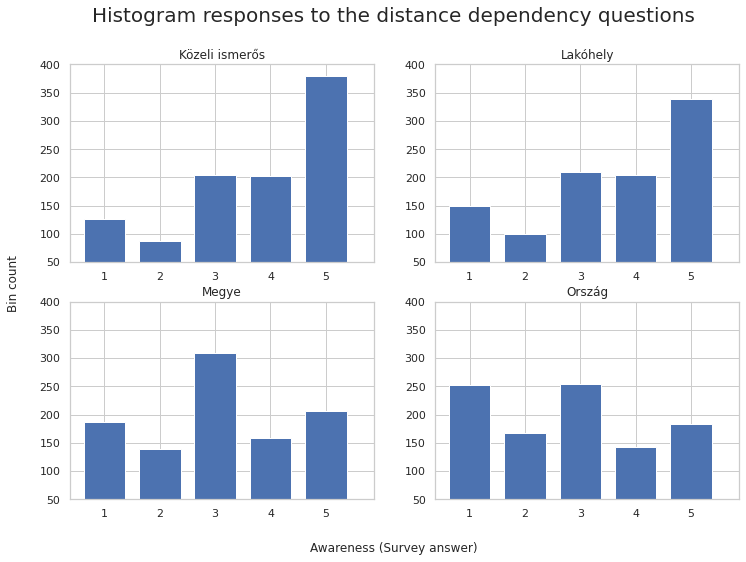

In [16]:
fig, axs = plt.subplots(2,2, figsize=(12,8))
w = 0.75
for ax, label in zip([axs[0,0], axs[0,1], axs[1,0], axs[1,1]],
                     ["Közeli ismerős", "Lakóhely", "Megye", "Ország"]):
    df[survey_column[label]].hist(ax=ax, bins=np.array([1,2,3,4,5,6])-w/2, width=w)
    ax.set_title(label)
    ax.set_ylim([50,400])


fig.text(0.5, 0.04, 'Awareness (Survey answer)', ha='center', va='center')
fig.text(0.06, 0.5, 'Bin count', ha='center', va='center', rotation='vertical')

fig.suptitle('Histogram responses to the distance dependency questions', fontsize=20);

## Megyeközponttól való távolságfüggés a megyén belül

In [17]:
def plot_koord(koords, y_num, n, label, ax, c):
    d = max(koords[:,0])

    bins = [((i/n)*d,((i+1)/n)*d) for i in range(n)]
    #print(bins)
    g_koord = []
    for b in bins:
        mem_in_bin = np.logical_and(koords[:,0]>b[0],koords[:,0]<=b[1] )
        g_koord.append((np.mean(koords[mem_in_bin, 0]),
                       np.mean(koords[mem_in_bin, y_num])))
        print(sum(mem_in_bin), end=" ")
    print(" ")
    g_koord = np.array(g_koord)
    
    ax.plot(g_koord[:,0], g_koord[:,1], 'o-', label=label, c=c)
    
def plot_koord2(koords, y_num, n, label, ax, c):
    d = max(koords[:,0])

    koords = np.array(sorted(koords, key=lambda l:l[0]))
    print(len(koords))
    g_koord=[]
    for i in range(n):
        a = int((i/n)*len(koords))
        b= int(len(koords)*(i+1)/n)
        
        g_koord.append((np.mean(koords[a:b, 0]),
                       np.mean(koords[a:b, y_num])))
    g_koord = np.array(g_koord)
    
    ax.plot(g_koord[:,0], g_koord[:,1], 'o-', label=label, c=c)
    
def l2(lat1,long1,county):
    lat2,long2 = county[1],county[2]
    return np.sqrt((lat2-lat1)**2+(long2-long1)**2)

def get_km(lat1,long1,county):
    lat2,long2 = county[1],county[2]
    
    lat1 = 2*np.pi*lat1/360
    lat2 = 2*np.pi*lat2/360
    long1 = 2*np.pi*long1/360
    long2 = 2*np.pi*long2/360
    
    R=6371
    a = np.sin((lat2-lat1)/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((long2-long1)/2)**2
    c = 2 * np.arctan2( np.sqrt(a), np.sqrt((1-a)) )
    d = R * c
    
    return d

In [18]:
megyeszekhely = df[df["settlement type"]=="megyeszékhely-megyei jogú város"].groupby(["K15A","admin county","latitude","longitude"]).size()
d_megyeszek = {r[1]:(r[0],r[2],r[3]) for r in megyeszekhely.index}
d_megyeszek["főváros"]=("Budapest",47.49801,19.03991)
d_megyeszek["Pest"]=("Budapest",47.49801,19.03991)

In [19]:


df["dist_from_county_center"]=df.apply(
    lambda l: get_km(l["latitude"],l["longitude"],d_megyeszek[l["admin county"]]),
    axis=1)

df["dist_from_Bp"]=df.apply(
    lambda l: get_km(l["latitude"],l["longitude"],(0,47.49801, 19.03991)),
    axis=1)

84 246 168 87 26 26 6 3  
84 246 168 87 26 26 6 3  


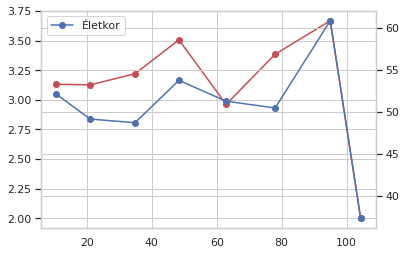

1000
1000


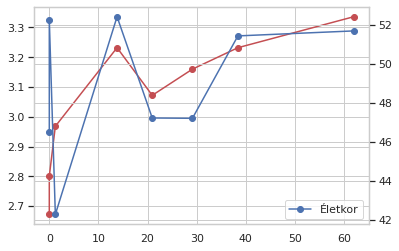

In [20]:
koords = np.array(list(zip(df["dist_from_county_center"], df["K91_03"], df["SZUL"])))
n=8
plot_koord(koords, 1, n, label="Awareness", ax=plt.gca(), c="r")
plot_koord(koords, 2, n, label="Életkor", ax=plt.gca().twinx(), c="b")
plt.legend()
plt.show()

koords = np.array(list(zip(df["dist_from_county_center"], df["K91_03"], df["SZUL"])))
n=8
plot_koord2(koords, 1, n, label="Awareness", ax=plt.gca(), c="r")
plot_koord2(koords, 2, n, label="Életkor", ax=plt.gca().twinx(), c="b")
plt.legend()

84 246 168 87 26 26 6 3  
84 246 168 87 26 26 6 3  


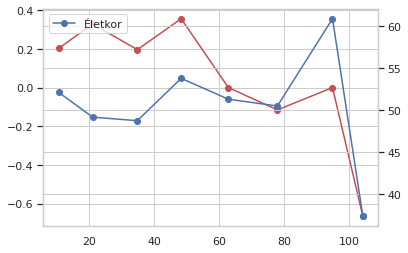

1000
1000


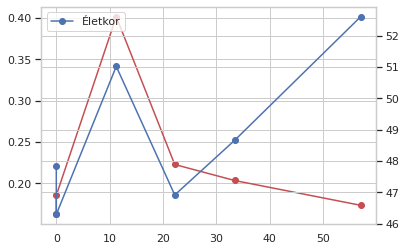

In [21]:
koords = np.array(list(zip(df["dist_from_county_center"], df["K91_03"]-df["K91_06"], df["SZUL"])))
n=8
plot_koord(koords, 1, n, label="Awareness", ax=plt.gca(), c="r")
plot_koord(koords, 2, n, label="Életkor", ax=plt.gca().twinx(), c="b")
plt.legend()
plt.show()

koords = np.array(list(zip(df["dist_from_county_center"], df["K91_03"]-df["K91_06"], df["SZUL"])))
n=6
plot_koord2(koords, 1, n, label="Awareness", ax=plt.gca(), c="r")
plot_koord2(koords, 2, n, label="Életkor", ax=plt.gca().twinx(), c="b")
plt.legend()